In [312]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import f_oneway
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

import warnings
warnings.filterwarnings("ignore")
# Running on google colab
# from pycaret.regression import setup, compare_models

In [6]:
# Read train and test dataset
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_label_clean.csv')
test_features = pd.read_csv('test_feature.csv')

## Overview

In [7]:
train_features.head(3)

,facilities,rating,location
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland


In [8]:
train_labels.head(3)

,Price
0,13500
1,13000
2,19000


In [9]:
test_features.head(3)

,ID,facilities,rating,location
0,0,GymrestaurantbarInternetSwimmingPools,8.0 ExcellentFrom 1 reviews,Stokol
1,1,Poolrestaurantgyminternetbar,7.4 Very GoodFrom 22 reviews,Hallerson
2,2,BARSwimmingPoolsInternetgym,0.0 FairFrom 4 reviews,Hallerson


## Merge the features with label

In [37]:
kyozo = pd.merge(train_features, train_labels_clean, left_index=True, right_index=True)
kyozo.head(3)

,facilities,rating,location,Price
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol,13500
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,13000
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland,19000


In [38]:
kyozo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   facilities  2765 non-null   object
 1   rating      2429 non-null   object
 2   location    3066 non-null   object
 3   Price       3066 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 95.9+ KB


## Check null and duplicated values

In [39]:
kyozo.duplicated().sum()

88

In [40]:
kyozo.isna().sum()

facilities    301
rating        637
location        0
Price           0
dtype: int64

### Drop null and duplicated values

In [41]:
kyozo.drop_duplicates(inplace=True)

In [42]:
kyozo.isna().sum()

facilities    243
rating        576
location        0
Price           0
dtype: int64

In [43]:
kyozo[kyozo['facilities'].isna() & kyozo['rating'].isna()]

,facilities,rating,location,Price
16,NaN,NaN,Machlessvile,3200
44,NaN,NaN,Uberlandia,17000
58,NaN,NaN,Stokol,1800
73,NaN,NaN,Stokol,23050
91,NaN,NaN,Stokol,30000
...,...,...,...,...
2975,NaN,NaN,Hallerson,3900
2996,NaN,NaN,Uberlandia,8000
2998,NaN,NaN,Machlessvile,3500
3030,NaN,NaN,Willsmian,3700


In [54]:
kyozo.dropna(subset=['facilities', 'rating'], how='all',inplace=True)

In [55]:
kyozo.isna().sum()

facilities     93
rating        426
location        0
Price           0
dtype: int64

In [63]:
kyozo.dropna(inplace=True)

## Check unique values

In [64]:
kyozo.nunique()

facilities    1076
rating         300
location         8
Price          129
dtype: int64

In [65]:
for col in kyozo.columns:
    print(col)
    print(kyozo[col].value_counts())
    print()

facilities
BARrestaurant                            56
Restaurant                               53
BARRestaurant                            50
RestaurantBar                            50
barrestaurant                            47
                                         ..
Gymrestaurantinternetswimmingpoolsbar     1
poolBarRestaurant                         1
Gymintrnetbarswimmingpools                1
PoolRestaurantintrnetbar                  1
Barrestaurantswimmingpools                1
Name: facilities, Length: 1076, dtype: int64

rating
10.0 ExcellentFrom 1 review     48
5.6 GoodFrom 1 review           23
8.8 ExcellentFrom 1 review      22
7.6 Very GoodFrom 2 reviews     21
8.0 ExcellentFrom 6 reviews     21
                                ..
7.3 Very GoodFrom 9 reviews      2
7.6 Very GoodFrom 12 reviews     2
6.8 Very GoodFrom 8 reviews      1
6.9 Very GoodFrom 3 reviews      1
7.5 Very GoodFrom 11 reviews     1
Name: rating, Length: 300, dtype: int64

location
Stokol          4

## Data Preprocessing

In [66]:
kyozo1 = kyozo.copy()
kyozo2 = test_features.copy()

In [67]:
kyozo_conc = pd.concat([kyozo1, kyozo2], axis=0, ignore_index=True)

In [68]:
kyozo_conc.head()

,facilities,rating,location,Price,ID
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol,13500.0,NaN
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,13000.0,NaN
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland,19000.0,NaN
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,6000.0,NaN
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol,20000.0,NaN


### Facilities Column

In [69]:
# Change to lowercase
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.lower()

In [70]:
# Check restaurant
kyozo_conc['fac_restaurant'] = kyozo_conc['facilities'].str.contains('restaurant') 
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('restaurant','')

In [71]:
# Check gym
kyozo_conc['fac_gym'] = kyozo_conc['facilities'].str.contains('gym') 
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('gym','')

In [72]:
# Check bar
kyozo_conc['fac_bar'] = kyozo_conc['facilities'].str.contains('bar') 
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('bar','')

In [73]:
# Check swimming pool
kyozo_conc['fac_swim'] = kyozo_conc['facilities'].str.contains('swim') | kyozo_conc['facilities'].str.contains('pool')
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('swimming','')
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('pool','')
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('pools','')


In [74]:
# Check internet
kyozo_conc['fac_internet'] = kyozo_conc['facilities'].str.contains('internet')  | kyozo_conc['facilities'].str.contains('intrnet')
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('internet','')
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('intrnet','')
kyozo_conc['facilities'] = kyozo_conc['facilities'].str.replace('s','')

In [75]:
# Change boolean to number and drop facilitites column
kyozo_conc.replace({False: 0, True: 1}, inplace=True)
kyozo_conc.drop(['facilities'],axis=1, inplace=True)

In [76]:
kyozo_conc.head()

,rating,location,Price,ID,fac_restaurant,fac_gym,fac_bar,fac_swim,fac_internet
0,7.8 Very GoodFrom 10 reviews,Stokol,13500.0,NaN,1,0,1,1,0
1,5.6 GoodFrom 4 reviews,Machlessvile,13000.0,NaN,1,1,0,0,1
2,7.2 Very GoodFrom 38 reviews,Wanderland,19000.0,NaN,1,1,1,1,0
3,7.3 Very GoodFrom 6 reviews,Uberlandia,6000.0,NaN,1,0,1,0,0
4,7.2 Very GoodFrom 30 reviews,Stokol,20000.0,NaN,1,0,0,0,1


### Rating Column

In [77]:
# Change to lowercase
kyozo_rate = kyozo_conc.copy()
kyozo_rate['rating'] = kyozo_rate['rating'].str.lower()

In [78]:
# Check very_good rate
kyozo_rate['very_good'] = kyozo_rate['rating'].str.findall(r'\b\w*very good').str.join(' ')

In [79]:
# Check fair rate
kyozo_rate['fair'] = kyozo_rate['rating'].str.findall(r'\b\w*fair').str.join(' ')

In [80]:
# Check excellent rate
kyozo_rate['excellent'] = kyozo_rate['rating'].str.findall(r'\b\w*excellent').str.join(' ')

In [81]:
# Check the rating
kyozo_rate['rate'] = kyozo_rate['rating'].str.extract(r'(\d+\.\d+)', expand=False)

In [82]:
# Check numer of reviews
kyozo_rate['num_of_reviews'] = kyozo_rate['rating'].str.extract(r'(\d+)\s*reviews?', expand=False)

In [83]:
# Concatenate fair and excellent rate with very_good rate
kyozo_rate['description'] = kyozo_rate['very_good'].str.cat([kyozo_rate['fair'], kyozo_rate['excellent']])

In [84]:
# Fill empty rows with good rate
kyozo_rate['description'].replace('','good',inplace=True)

In [85]:
# Drop unused column
kyozo_rate.drop(['very_good','fair','excellent','rating'],axis=1,inplace=True)

In [86]:
# Check null
kyozo_rate_with_null = kyozo_rate.copy()
kyozo_rate_with_null['rate'].isna().sum()

23

In [88]:
# Get the index of null values and drop it
rate_null = kyozo_rate_with_null.loc[kyozo_rate_with_null['rate'].isna()].index.tolist()
kyozo_rate_with_null.drop(rate_null, axis=0,inplace=True)

kyozo_rate_no_null = kyozo_rate_with_null.copy()
kyozo_rate_no_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3075
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        3053 non-null   object 
 1   Price           2286 non-null   float64
 2   ID              767 non-null    float64
 3   fac_restaurant  3053 non-null   int64  
 4   fac_gym         3053 non-null   int64  
 5   fac_bar         3053 non-null   int64  
 6   fac_swim        3053 non-null   int64  
 7   fac_internet    3053 non-null   int64  
 8   rate            3053 non-null   object 
 9   num_of_reviews  3053 non-null   object 
 10  description     3053 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 286.2+ KB


In [89]:
# Change to appropriate data type
kyozo_rate_no_null['rate'] = pd.to_numeric(kyozo_rate_no_null['rate'])
kyozo_rate_no_null['num_of_reviews'] = pd.to_numeric(kyozo_rate_no_null['num_of_reviews'])

In [90]:
kyozo_rate_no_null.head()

,location,Price,ID,fac_restaurant,fac_gym,fac_bar,fac_swim,fac_internet,rate,num_of_reviews,description
0,Stokol,13500.0,NaN,1,0,1,1,0,7.8,10,very good
1,Machlessvile,13000.0,NaN,1,1,0,0,1,5.6,4,good
2,Wanderland,19000.0,NaN,1,1,1,1,0,7.2,38,very good
3,Uberlandia,6000.0,NaN,1,0,1,0,0,7.3,6,very good
4,Stokol,20000.0,NaN,1,0,0,0,1,7.2,30,very good


### Label and One Hot Encoding

In [91]:
# Replace description to ordinal number
kyozo_rate_no_null['description'].replace({'excellent':4,'very good': 3, 'good': 2, 'fair':1}, inplace=True)

In [92]:
# OHE
kyozo_ohe = pd.get_dummies(kyozo_rate_no_null, columns=['location'], drop_first=True)

In [93]:
kyozo_ohe.head()

,Price,ID,fac_restaurant,fac_gym,fac_bar,fac_swim,fac_internet,rate,num_of_reviews,description,location_Hallerson,location_Machlessvile,location_Stokol,location_Uberlandia,location_Ubisville,location_Wanderland,location_Willsmian
0,13500.0,NaN,1,0,1,1,0,7.8,10,3,0,0,1,0,0,0,0
1,13000.0,NaN,1,1,0,0,1,5.6,4,2,0,1,0,0,0,0,0
2,19000.0,NaN,1,1,1,1,0,7.2,38,3,0,0,0,0,0,1,0
3,6000.0,NaN,1,0,1,0,0,7.3,6,3,0,0,0,1,0,0,0
4,20000.0,NaN,1,0,0,0,1,7.2,30,3,0,0,1,0,0,0,0


## EDA

### Distribution

Text(0.5, 1.0, 'Before Normalize')

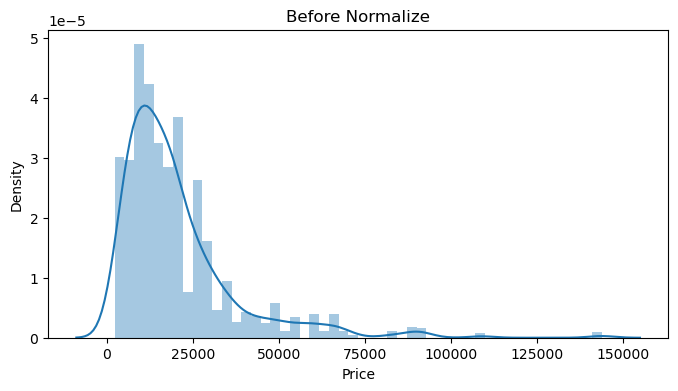

In [95]:
# Price dist
plt.figure(figsize=(8,4))
sns.distplot(kyozo_ohe['Price'], kde=True)
plt.title('Before Normalize')

Text(0.5, 1.0, 'After Normalize')

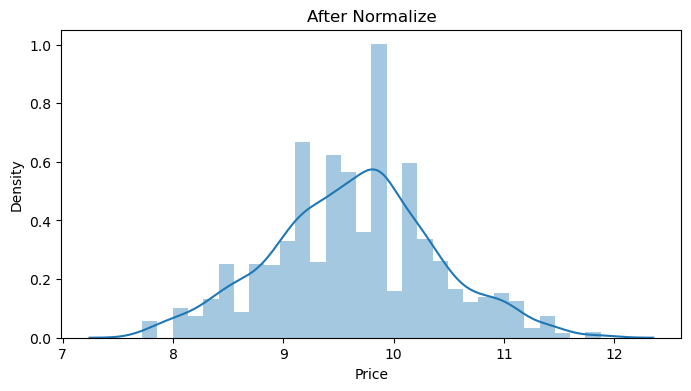

In [96]:
# Price dist
plt.figure(figsize=(8,4))
sns.distplot(np.log(kyozo_ohe['Price']), kde=True)
plt.title('After Normalize')

### Correlation before Feature Engineering

In [97]:
# Just use training data
kyozo_training_tmp = kyozo_ohe.iloc[:-767,:].copy().drop('ID',axis=1)

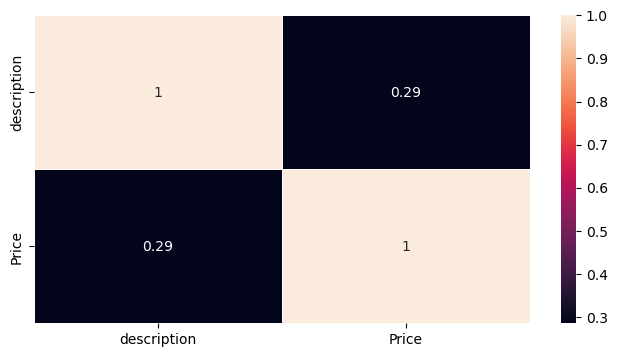

In [98]:
# Description with price (spearman)
plt.figure(figsize=(8, 4))
sns.heatmap(kyozo_training_tmp[['description','Price']].corr(method='spearman'), annot=True, linewidths=0.5)
plt.show()

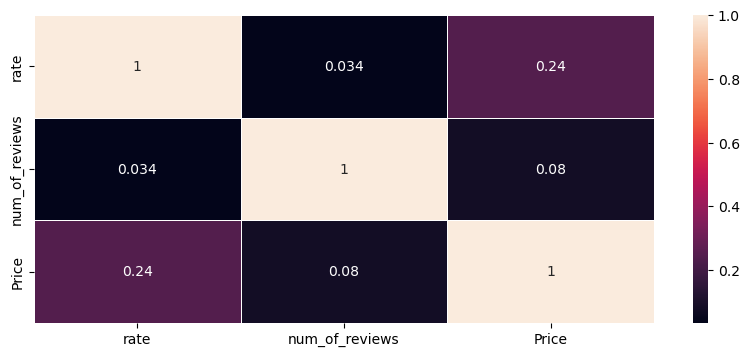

In [99]:
# Numeric data with price (pearson)
plt.figure(figsize=(10, 4))
sns.heatmap(kyozo_training_tmp[['rate','num_of_reviews','Price']].corr(method='pearson'), annot=True, linewidths=0.5);
plt.show()

In [100]:
binary_columns = ['fac_restaurant', 'fac_gym', 'fac_bar', 'fac_swim',
       'fac_internet', 'location_Hallerson', 'location_Machlessvile', 'location_Stokol',
       'location_Uberlandia', 'location_Ubisville', 'location_Wanderland',
       'location_Willsmian']

correlations = []
for col in binary_columns:
    correlation, p_value = stats.pointbiserialr(kyozo_training_tmp[col], kyozo_training_tmp['Price'])
    correlations.append((col, correlation, p_value))

for i in range(len(binary_columns)):
    print(correlations[i][:2])

('fac_restaurant', 0.048328745713047995)
('fac_gym', 0.257151224586477)
('fac_bar', 0.08387899647773668)
('fac_swim', 0.3184947592647387)
('fac_internet', 0.2320414983109023)
('location_Hallerson', 0.01692567657998713)
('location_Machlessvile', 0.03838759021682703)
('location_Stokol', -0.027456639193179037)
('location_Uberlandia', 0.02620605574497787)
('location_Ubisville', -0.013058907930175456)
('location_Wanderland', -0.028989904754176107)
('location_Willsmian', -0.002647647379079158)


## Feature Engineering

In [101]:
# Based on point-biserrial correlation
fac_internet_coef = 23
fac_swim_coef = 32
fac_bar_coef = 8
fac_gym_coef = 26
fac_restaurant_coef = 48

In [102]:
# Get the weight of each facilities columns (real value * coef)
kyozo_ohe['fac_internet_cost'] = kyozo_ohe['fac_internet'] * fac_internet_coef
kyozo_ohe['fac_swim_cost'] = kyozo_ohe['fac_swim'] * fac_swim_coef
kyozo_ohe['fac_bar_cost'] = kyozo_ohe['fac_bar'] * fac_bar_coef
kyozo_ohe['fac_gym_cost'] = kyozo_ohe['fac_gym'] * fac_gym_coef
kyozo_ohe['fac_restaurant_cost'] = kyozo_ohe['fac_restaurant'] * fac_restaurant_coef

# Get the total weight of each facilities columns
kyozo_ohe['jumlah_fac_cost'] = kyozo_ohe['fac_internet_cost'] + kyozo_ohe['fac_swim_cost'] + kyozo_ohe['fac_bar_cost'] + kyozo_ohe['fac_gym_cost'] + kyozo_ohe['fac_restaurant_cost']

In [103]:
# Get the popularity of each places (rate * num of reviews)
kyozo_ohe['popularity'] = kyozo_ohe['rate'] * kyozo_ohe['num_of_reviews']

In [104]:
# Get the number of facilities of each rows
kyozo_ohe['jumlah_fasilitas'] = kyozo_ohe['fac_restaurant'] + kyozo_ohe['fac_gym'] + kyozo_ohe['fac_swim'] + kyozo_ohe['fac_internet'] + kyozo_ohe['fac_bar']

In [105]:
# Get the weight of facilities number
kyozo_ohe['fasilitas_cost_multiply'] = kyozo_ohe['jumlah_fasilitas'] * kyozo_ohe['jumlah_fac_cost']

In [106]:
# Copy to new variable
kyozo_combined = kyozo_ohe.copy()

In [107]:
# Assign the features into variable based on their type
binary_list = ['fac_restaurant', 'fac_gym', 'fac_bar', 'fac_swim',
       'fac_internet', 'location_Hallerson', 'location_Machlessvile', 'location_Stokol',
       'location_Uberlandia', 'location_Ubisville', 'location_Wanderland',
       'location_Willsmian']

numeric_list = ['rate','num_of_reviews','jumlah_fasilitas','fac_internet_cost','fac_gym_cost',
        'fac_bar_cost','fac_restaurant_cost','fac_swim_cost','jumlah_fac_cost','popularity',
        'fasilitas_cost_multiply']

### Correlation after Feature Engineering

In [108]:
# Split the test set and train set according to the csv lines
kyozo_training = kyozo_combined.iloc[:-767,:].copy().drop('ID',axis=1)

kyozo_test_X = kyozo_combined.iloc[-767:, :].copy().drop(['Price','ID'], axis=1)
kyozo_test_ID = kyozo_combined.iloc[-767:, :]['ID']

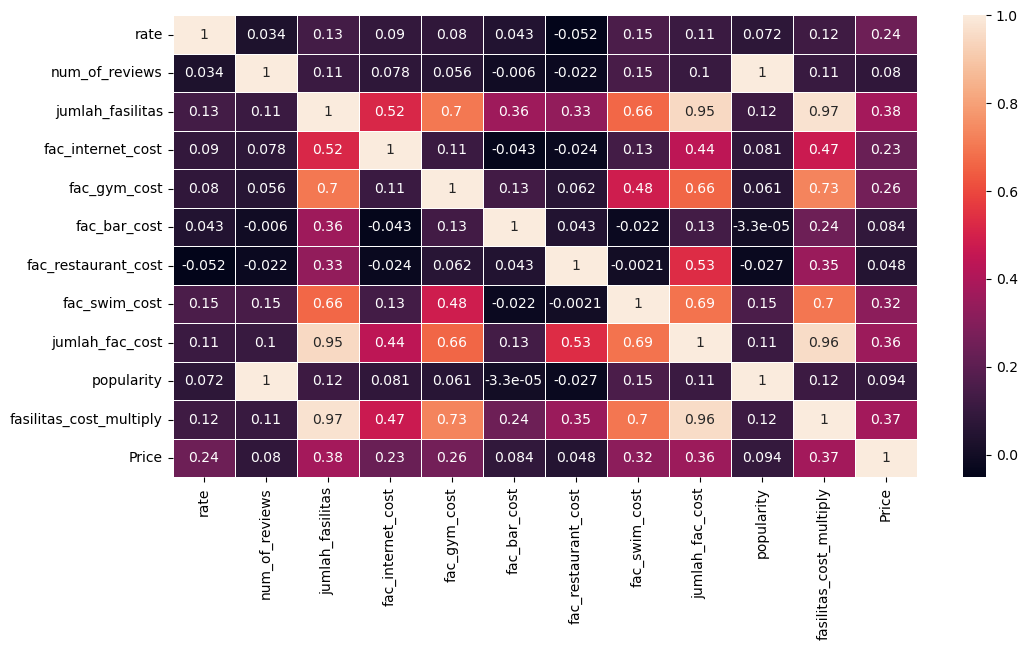

In [109]:
# Numeric data with price (pearson)
plt.figure(figsize=(12, 6))
sns.heatmap(kyozo_training[numeric_list + ['Price']].corr(method='pearson'), annot=True, linewidths=0.5);
plt.show()

In [110]:
# Custom features
custom_features = ['fac_gym_cost','fac_restaurant_cost','fac_internet_cost','fac_swim_cost','fac_bar_cost']

### Drop outlier

In [112]:
kyozo_training['Price'] = np.log(kyozo_training['Price'])

In [114]:
def find_outliers(data):
    bad_indexes = []
    column_names = []
    for col in data.columns:
        if data[col].dtype in ["int64","float64"] and col == 'Price':
            column_names.append(col)
            q1 = data[col].quantile(.25)
            q3 = data[col].quantile(.75)
            IQR = q3 - q1
            ll = q1 - (1.5*IQR)
            ul = q3 + (1.5*IQR)
            upper_outliers = data[col][data[col] > ul].index.tolist()
            lower_outliers = data[col][data[col] < ll].index.tolist()
            bad_indices = list(set(upper_outliers + lower_outliers))
            bad_indexes.append(bad_indices)
    return bad_indexes, column_names

In [115]:
# Check the outliers in training dataset
outlier_index, column_names = find_outliers(kyozo_training)
    
lst_of_lens = []
for i in outlier_index:
    lst_of_lens.append(len(i))
list_tuples = list(zip(column_names, lst_of_lens))

df_outlier = pd.DataFrame(list_tuples, columns=['nama_kolom', 'jumlah_outlier'])
df_outlier

,nama_kolom,jumlah_outlier
0,Price,14


In [116]:
# Drop the outliers
set_index = set()
for i in outlier_index:
    for j in i:
        set_index.add(j)

dropped_kyozo_training = kyozo_training.drop(set_index, axis=0)

print("ukuran sebelum di drop", kyozo_training.shape)
print("ukuran setelah di drop", dropped_kyozo_training.shape)

ukuran sebelum di drop (2286, 25)
ukuran setelah di drop (2272, 25)


In [117]:
# Split training data to features and target
kyozo_train_X = dropped_kyozo_training.drop(['Price'],axis=1)
kyozo_train_Y = dropped_kyozo_training['Price']

## Training

In [121]:
# Split feature and target
X = kyozo_train_X.copy()
Y = kyozo_train_Y.copy()

In [123]:
# Drop unused columns because have low corr
X_drop_binary = X.drop(binary_list, axis=1)

### Feature Selection

In [125]:
# Feature selection using RFE with DecisionTreeRegressor model
rfe = RFE(estimator=DecisionTreeRegressor(random_state=42), n_features_to_select=5)
model = DecisionTreeRegressor(random_state=42)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# Evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_drop_binary, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# Report performance
print('MAE: %.3f (%.3f)' % (np.mean(-(n_scores)), np.std(n_scores)))

MAE: 0.023 (0.010)


In [73]:
# Tried to use gridsearch to get the best parameters
param_grid = {
    "criterion":['squared_error', 'absolute_error', 'poisson'],
    "max_depth": [3,5,10,15,20,30,40,None],
    "max_leaf_nodes": [100,200,300,400,500,None],
    "min_samples_split": [1,2,3,5,10],
    "min_samples_leaf": [1,2,5],
    "max_features": ['sqrt', 'log2',None],
    "ccp_alpha":[0.0,0.01,0.1,0.15,0.2]
}

clf = DecisionTreeRegressor(random_state=42)
grid_cv = GridSearchCV(clf, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=4).fit(X_train, y_train)

Param for GS {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 30, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
CV score for GS -0.029308812115725072
Train MAE Score for GS:  0.010920357311125064
Test MAE Score for GS:  0.03653388041699337

In [283]:
rfe = RFE(estimator=DecisionTreeRegressor(random_state=42,
    ccp_alpha= 0.00,
    criterion= 'absolute_error',
    max_depth= 30, max_features= None,
    max_leaf_nodes= None, 
    min_samples_leaf= 1, 
    min_samples_split= 3), n_features_to_select=3, step=1)
rfe.fit(X_drop_binary,Y)
X_rfe = rfe.transform(X_drop_binary)

# for model selection using pycaret, running on google colab
selected_features = X_drop_binary.columns[rfe.support_]
df_selected = pd.concat([X_drop_binary[selected_features], Y], axis=1)

rfe.get_feature_names_out()

array(['rate', 'popularity', 'fasilitas_cost_multiply'], dtype=object)

In [284]:
# # Running on google colab
# _ = setup(data=df_selected, target='Price')
# compare_models()

### Train Test Split

In [285]:
# Split train test for RFE
X_train, X_test, y_train, y_test = train_test_split(X_rfe, Y, test_size=0.2, random_state=42)

In [286]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [287]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [288]:
def eval(train, test, predict_train, predict_test):
    print('MAE Train: ', mean_absolute_error(train, predict_train))
    print('MAE Test: ', mean_absolute_error(test, predict_test))
    print('MAE Train exp: ', mean_absolute_error(np.exp(train), np.exp(predict_train)))
    print('MAE Test exp: ', mean_absolute_error(np.exp(test), np.exp(predict_test)))

### Decision Tree Reg

In [289]:
# DTR using RFE
dtr = DecisionTreeRegressor(random_state=42,
    ccp_alpha= 0.00,
    criterion= 'absolute_error',
    max_depth= 30, max_features= None,
    max_leaf_nodes= None, 
    min_samples_leaf= 1, 
    min_samples_split= 3)
dtr.fit(X_train, y_train)
dtr_predict_train = dtr.predict(X_train)
dtr_predict_test = dtr.predict(X_test)

# Evaluation Metrics
print('Evaluation using features from RFE:')
eval(y_train, y_test, dtr_predict_train, dtr_predict_test)

Evaluation using features from RFE:
MAE Train:  0.011117102414328608
MAE Test:  0.04487049652131421
MAE Train exp:  117.33626857457355
MAE Test exp:  619.7761859234195


### Linear Regression

In [290]:
# LR using RFE
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict_train = lr.predict(X_train)
lr_predict_test = lr.predict(X_test)

# Evaluation Metrics
print('Evaluation using features from RFE:')
eval(y_train, y_test, lr_predict_train, lr_predict_test)

Evaluation using features from RFE:
MAE Train:  0.48723288689298266
MAE Test:  0.48182530859988404
MAE Train exp:  9272.854092948823
MAE Test exp:  8867.233060173392


### Random Forest

In [291]:
# RF using RFE
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
rfr_predict_train = rfr.predict(X_train)
rfr_predict_test = rfr.predict(X_test)

# Evaluation Metrics
print('Evaluation using features from RFE:')
eval(y_train, y_test, rfr_predict_train, rfr_predict_test)

Evaluation using features from RFE:
MAE Train:  0.02373880309342345
MAE Test:  0.05723457920443566
MAE Train exp:  280.7505978063257
MAE Test exp:  794.6373865901446


### XGB

In [292]:
# XG Boost
xg = XGBRegressor(random_state=42)
xg.fit(X_train, y_train)
xg_predict_train = xg.predict(X_train)
xg_predict_test = xg.predict(X_test)

# Evaluation Metrics
print('Evaluation using features from RFE:')
eval(y_train, y_test, xg_predict_train, xg_predict_test)

Evaluation using features from RFE:
MAE Train:  0.028238242411309154
MAE Test:  0.0493796743215351
MAE Train exp:  431.4180969339059
MAE Test exp:  695.6538187886325


### Extra Trees Regressor

In [293]:
# XTR RFE
xtr = ExtraTreesRegressor()
xtr.fit(X_train, y_train)
xtr_predict_train = xtr.predict(X_train)
xtr_predict_test = xtr.predict(X_test)

# Evaluation Metrics
print('Evaluation using features from select RFE:')
eval(y_train, y_test, xtr_predict_train, xtr_predict_test)

Evaluation using features from select RFE:
MAE Train:  0.014224696522322635
MAE Test:  0.035250401653081916
MAE Train exp:  147.01767510873123
MAE Test exp:  394.9670206213502


## SUBMISI

In [295]:
kyozo_test = kyozo_test_X[rfe.get_feature_names_out()]

In [296]:
kyozo_test

,rate,popularity,fasilitas_cost_multiply
2309,8.0,8.0,685
2310,7.4,162.8,685
2311,0.0,0.0,356
2312,6.8,88.4,685
2313,0.0,0.0,685
...,...,...,...
3071,8.1,72.9,456
3072,8.0,32.0,685
3073,7.4,140.6,685
3074,9.0,153.0,685


In [297]:
kyozo_test_X_scaled = pd.DataFrame(scaler.transform(kyozo_test), index=kyozo_test.index, columns=kyozo_test.columns)

In [307]:
predictions_log = rfr.predict(kyozo_test_X_scaled)

In [308]:
predictions = np.exp(predictions_log)

In [309]:
df = pd.DataFrame()
df['ID'] = kyozo_test_ID
df['Price'] = predictions

In [310]:
result = df.astype('int')
result.head()

,ID,Price
2309,0,23813
2310,1,25519
2311,2,18856
2312,3,9822
2313,4,24380


In [311]:
# result.to_csv('test8.csv',index=False)

In [97]:
# ----FINISH----

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c5ca1f0b-b267-41d3-8cca-2b97cce44ef4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>